In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_final = pd.read_csv("cleaned_fraud_data.csv")
df_final.head()

,category,amt,gender,dob,transaction_hour,is_fraud
0,13,8.49,0,69,22,1
1,10,4.37,1,25,16,0
2,8,738.31,0,54,16,1
3,12,795.01,1,30,23,1
4,7,64.94,0,54,16,0


In [ ]:
X = df_final[['category', 'amt', 'gender', 'dob', 'transaction_hour']]
y = df_final[['is_fraud']]

print("Shape of independent variables table:", X.shape)
print("Shape of target variable table:", y.shape)

Shape of independent variables table: (19302, 5)
Shape of target variable table: (19302, 1)


## Comparing 8 classifiers using lazypredict

In [ ]:
!pip install lazypredict 

In [ ]:
import lazypredict 
from lazypredict import Supervised 
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (10,5)

# train-test split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.5, random_state=12)

In [ ]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     random_state=12,
                     classifiers='all',
                    )
models, predictions = clf.fit(X_train, X_valid, y_train, y_valid)

 90%|█████████████████████████████████████████████████████████████████████████▌        | 26/29 [00:37<00:04,  1.35s/it]

[08:57:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:38<00:00,  1.33s/it]


In [ ]:
models.head(8)

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.98,0.98,0.98,0.98,0.29
RandomForestClassifier,0.98,0.98,0.98,0.98,1.81
XGBClassifier,0.97,0.97,0.97,0.97,1.08
ExtraTreesClassifier,0.97,0.97,0.97,0.97,1.38
BaggingClassifier,0.97,0.97,0.97,0.97,0.38
DecisionTreeClassifier,0.97,0.97,0.97,0.97,0.10
ExtraTreeClassifier,0.95,0.95,0.95,0.95,0.06
KNeighborsClassifier,0.94,0.94,0.94,0.94,0.81


In [ ]:
models["Accuracy"][0:8]

Model
LGBMClassifier           0.98
RandomForestClassifier   0.98
XGBClassifier            0.97
ExtraTreesClassifier     0.97
BaggingClassifier        0.97
DecisionTreeClassifier   0.97
ExtraTreeClassifier      0.95
KNeighborsClassifier     0.94
Name: Accuracy, dtype: float64

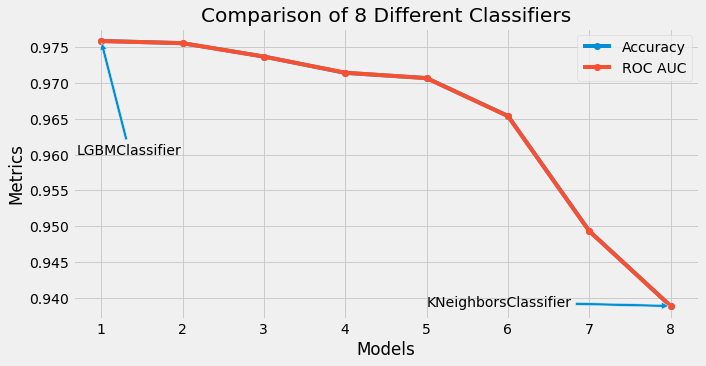

In [ ]:
idx = [i for i in range(1,28)]
plt.plot(idx[0:8], models["Accuracy"][0:8]  ,marker='o' , label = "Accuracy" )
plt.plot(idx[0:8], models["ROC AUC"][0:8] , marker ='o' , label = "ROC AUC")
plt.annotate(models.index[0] , 
             (1, models["Accuracy"][0]) , 
             xytext = (0.7, 0.96),
             arrowprops = dict(
                               arrowstyle = "simple"
                              ))
plt.annotate(models.index[7] , 
             (8, models["Accuracy"][7]) , 
             xytext = (5, models["Accuracy"][7]),
             arrowprops = dict(
                               arrowstyle = "simple"
                              ))
plt.xlabel("Models")
plt.ylabel("Metrics")
plt.title("Comparison of 8 Different Classifiers")
plt.legend()
plt.show()

## XGBOOST Classifier

In [ ]:
import xgboost as xgb
my_model = xgb.XGBClassifier()
my_model.fit(X_train, y_train)

XGBClassifier()

In [ ]:
import sklearn.metrics as metrics
y_pred = my_model.predict_proba(X_valid)[:,1]
print("ROC AUC before parameter tuning:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC before parameter tuning: 0.9943464540863831


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = my_model.predict(X_valid)
y_pred = [round(value) for value in y_pred]

# Evaluate predictions
accuracy_score(y_valid, y_pred)

0.9675681276551653

### Hyper-Parameter Tuning

In [ ]:
# For hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_valid, y_valid)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.9183504300072531
SCORE:
0.9274686560978137
SCORE:
0.9248782509584499
SCORE:
0.9181431975961041
SCORE:
0.9246710185473008
SCORE:
0.9268469588643664
SCORE:
0.9249818671640244
SCORE:
0.9227023106413843
SCORE:
0.9206299865298933
SCORE:
0.9262252616309191
SCORE:
0.9245674023417263
SCORE:
0.9261216454253445
SCORE:
0.9263288778364936
SCORE:
0.9175215003626567
SCORE:
0.9198010568852969
SCORE:
0.9245674023417263
SCORE:
0.9251890995751736
SCORE:
0.92601802921977
SCORE:
0.9262252616309191
SCORE:
0.9247746347528754
SCORE:
0.9282975857424101
SCORE:
0.9261216454253445
SCORE:
0.9287120505647083
SCORE:
0.9288156667702828
SCORE:
0.9250854833695991
SCORE:
0.92715780748109
SCORE:
0.9238420889027044
SCORE:
0.9234276240804061
SCORE:
0.9272614236866646
SCORE:
0.9188685110351259
SCORE:
0.9186612786239768
SCORE:
0.9243601699305771
SCORE:
0.9239457051082789
SCORE:
0.9254999481918972
SCORE:
0.9261216454253445
SCORE:
0.9247746347528754
SCORE:
0.9199046730908714
SCORE:
0.9242565537250026
SCORE:
0.9248782

In [ ]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5056727415309088, 'gamma': 2.2214829868744967, 'max_depth': 12.0, 'min_child_weight': 3.0, 'reg_alpha': 41.0, 'reg_lambda': 0.998085867812219}


In [ ]:
tuned_xgb = xgb.XGBClassifier(colsample_bytree= 0.998807267028738, gamma= 1.321962425893548,max_depth=10, min_child_weight= 0.0, reg_alpha=43.0, reg_lambda= 0.4888063780234211)
tuned_xgb.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.998807267028738, gamma=1.321962425893548,
              max_depth=10, min_child_weight=0.0, reg_alpha=43.0,
              reg_lambda=0.4888063780234211)

In [ ]:
y_pred = tuned_xgb.predict(X_valid)
y_pred = [round(value) for value in y_pred]

# Evaluate predictions
accuracy_score(y_valid, y_pred)

0.9547197181639209

In [ ]:
y_pred = tuned_xgb.predict_proba(X_valid)[:,1]
print("ROC AUC after parameter tuning:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC after parameter tuning: 0.9903530152359397


After comparing ROC AUC of before and after parameter tuning, we can conclude that our model is performing better without tuning and has the best parameters by default.

## LightGBM Classifier

In [ ]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [ ]:
y_pred = model.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9746140296342348

In [ ]:
y_pred = model.predict_proba(X_valid)[:,1]
print("ROC AUC before parameter tuning:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC before parameter tuning: 0.9970899865595554


### Hyper-Parameter Tuning of LightGBM Classifier

In [ ]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

fit_params = {"early_stopping_rounds":30, "eval_metric" : 'auc', "eval_set" : [(X_valid,y_valid)],
            'eval_names': ['valid'], 'verbose': 100, 'categorical_feature': 'auto'}

test_params = {'num_leaves': sp_randint(6, 50), 'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

# Parameter defining the number of HP points to be tested
hp_points = 100

# n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
gs = RandomizedSearchCV(estimator=clf, param_distributions=test_params, 
    n_iter=hp_points, scoring='roc_auc', cv=3, refit=True, random_state=314, verbose=True)

# Optimal parameters
opt_parameters = {'colsample_bytree': 0.9234, 'min_child_samples': 399, 'min_child_weight': 0.1, 'num_leaves': 13, 'reg_alpha': 2, 'reg_lambda': 5, 'subsample': 0.855}

clf_sw = lgb.LGBMClassifier(**clf.get_params())
# Set optimal parameters
clf_sw.set_params(**opt_parameters)

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

In [ ]:
gs_sample_weight = GridSearchCV(estimator=clf_sw, param_grid={'scale_pos_weight':[1,2,6,12]},
                                scoring='roc_auc', cv=5, refit=True, verbose=True)

gs_sample_weight.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs_sample_weight.best_score_, gs_sample_weight.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.992572
[200]	valid's auc: 0.99517
[300]	valid's auc: 0.995826
[400]	valid's auc: 0.996072
[500]	valid's auc: 0.996188
Early stopping, best iteration is:
[504]	valid's auc: 0.996195
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.993436
[200]	valid's auc: 0.995431
[300]	valid's auc: 0.995939
[400]	valid's auc: 0.996175
[500]	valid's auc: 0.996291
[600]	valid's auc: 0.996425
Early stopping, best iteration is:
[665]	valid's auc: 0.99649
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.993013
[200]	valid's auc: 0.995134
[300]	valid's auc: 0.995832
[400]	valid's auc: 0.996166
[500]	valid's auc: 0.996324
[600]	valid's auc: 0.996437
Early stopping, best iteration is:
[636]	valid's auc: 0.996451
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.992869
[

In [ ]:
def learning_rate_decay_power(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(0.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

# Configure locally from hardcoded values
clf_final = lgb.LGBMClassifier(**clf.get_params())

# Set optimal parameters
clf_final.set_params(**opt_parameters)

# Train the final model with learning rate decay
clf_final.fit(X_train, y_train, **fit_params, callbacks=[lgb.reset_parameter(learning_rate = learning_rate_decay_power)])

Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.993655
[200]	valid's auc: 0.995442
[300]	valid's auc: 0.996006
[400]	valid's auc: 0.996203
[500]	valid's auc: 0.996291
[600]	valid's auc: 0.996345
[700]	valid's auc: 0.996378
[800]	valid's auc: 0.996397
[900]	valid's auc: 0.996407
[1000]	valid's auc: 0.996415
[1100]	valid's auc: 0.996423
[1200]	valid's auc: 0.996431
[1300]	valid's auc: 0.996436
[1400]	valid's auc: 0.996444
[1500]	valid's auc: 0.99645
[1600]	valid's auc: 0.996458
[1700]	valid's auc: 0.996466
[1800]	valid's auc: 0.996473
[1900]	valid's auc: 0.996478
[2000]	valid's auc: 0.996484
[2100]	valid's auc: 0.996493
[2200]	valid's auc: 0.996499
[2300]	valid's auc: 0.996505
[2400]	valid's auc: 0.996511
[2500]	valid's auc: 0.996516
[2600]	valid's auc: 0.996521
[2700]	valid's auc: 0.996528
[2800]	valid's auc: 0.996536
[2900]	valid's auc: 0.996542
[3000]	valid's auc: 0.996548
[3100]	valid's auc: 0.996554
[3200]	valid's auc: 0.99656
[3300]	valid's auc: 0

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

In [ ]:
clf_final

LGBMClassifier(colsample_bytree=0.9234, metric='None', min_child_samples=399,
               min_child_weight=0.1, n_estimators=5000, n_jobs=4, num_leaves=13,
               random_state=314, reg_alpha=2, reg_lambda=5, subsample=0.855)

In [ ]:
y_pred = clf_final.predict_proba(X_valid)[:,1]
print("ROC AUC after parameter tuning:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC after parameter tuning: 0.9966666013884338


After comparing ROC AUC of before and after parameter tuning, we can conclude that our model is performing better without tuning and has the best parameters by default.

## RandomForest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier() 
clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9763755051290022

In [ ]:
y_pred = clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC before parameter tuning: 0.9965290232177497


## Extra Trees Classifier

**Extremely Randomized Trees Classifier(Extra Trees Classifier)** is a type of ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it’s classification result. In concept, it is very similar to a Random Forest Classifier and only differs from it in the manner of construction of the decision trees in the forest.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ex_clf = ExtraTreesClassifier()
ex_clf.fit(X_train, y_train)

ExtraTreesClassifier()

In [ ]:
y_pred = ex_clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9711946948502745

In [ ]:
y_pred = ex_clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC before parameter tuning: 0.9951576864432227


## Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dc_clf = DecisionTreeClassifier()
dc_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = dc_clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9654958035436743

In [ ]:
y_pred = dc_clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC before parameter tuning: 0.9654771770118924


## Bagging Classifier

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection

kfold = model_selection.KFold(n_splits = 3)

# Initialize the base classifier
base_cls = DecisionTreeClassifier()

# no. of base classifier
num_trees = 50
# bagging classifier
model = BaggingClassifier(base_estimator = base_cls,
                          n_estimators = num_trees)

results = model_selection.cross_val_score(model, X_valid, y_valid, cv = kfold)
results.max()

0.9751321106621076

In [ ]:
results.mean()

0.9724380893171691

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.972956170345042

In [ ]:
y_pred = model.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC before parameter tuning: 0.9948265711955331


## ExtraTree Classifier

In [ ]:
ex_clf = ExtraTreesClassifier(n_estimators=1)
ex_clf.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=1)

In [ ]:
y_pred = ex_clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.949124443062895

In [ ]:
y_pred = ex_clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC: 0.9491035280136383


## KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k_clf = KNeighborsClassifier()
k_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = k_clf.predict(X_valid)
y_pred = [round(value) for value in y_pred]

accuracy_score(y_valid, y_pred)

0.9486063620350222

In [ ]:
y_pred = k_clf.predict_proba(X_valid)[:,1]
print("ROC AUC:", metrics.roc_auc_score(y_valid, y_pred))

ROC AUC: 0.9805046557122921


### Conclusion

After observing and comparing total of 8 different classifiers, we saw that LightGBMClassifier, XGBoost, and RandonForestClassifier are performing approximately similar but LightGBMClassifier is 3 times faster which will boost the performace of our overall system. So we will be using **LightGBMClassifier**.